In [59]:
# Do not modify
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# inline plotting instead of popping out
%matplotlib inline

df = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv',
    sep=',')
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [60]:
# Do not modify
df = df.drop(['cbwd'], axis=1)  # drop non-scalar feature
df = df.dropna(axis=0, how='any')  # drop samples who has nan feature
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,2,0


In [61]:
# Do not modify
idX = np.logical_or(
    np.logical_and(df['year'].values == 2014, df['month'].values < 3),
    np.logical_and(df['year'].values == 2013, df['month'].values == 12))
X = df.loc[idX].drop('pm2.5', axis=1)
y = df.loc[idX]['pm2.5'].values
X.head()

,No,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir
34320,34321,2013,12,1,0,-13,-2.0,1026.0,0.89,0,0
34321,34322,2013,12,1,1,-14,-3.0,1025.0,3.13,0,0
34322,34323,2013,12,1,2,-13,-3.0,1025.0,0.89,0,0
34323,34324,2013,12,1,3,-13,-4.0,1025.0,0.89,0,0
34324,34325,2013,12,1,4,-13,-3.0,1025.0,1.78,0,0


### Feature Selection

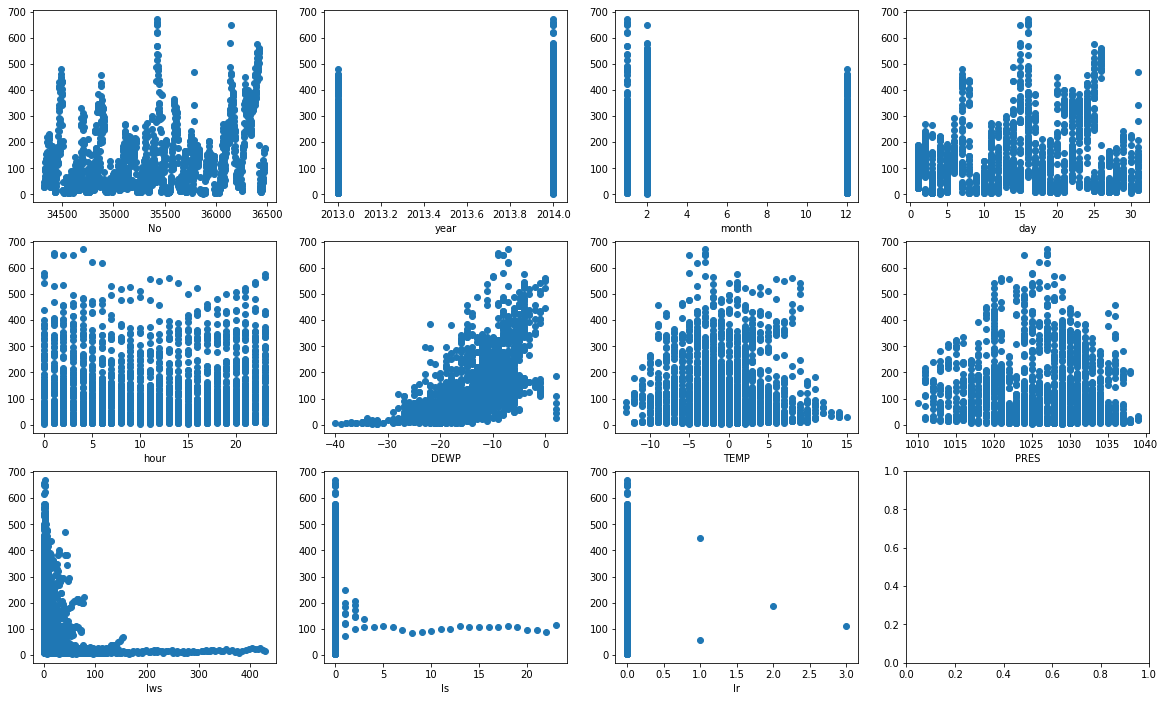

In [62]:
x_vars = [
    'No', 'year','month','day','hour','DEWP','TEMP','PRES','Iws','Is','Ir'
]

_, subplot_arr = plt.subplots(3, 4, figsize=(20, 12))
for idx, x_var in enumerate(x_vars):
    x_idx = idx // 4
    y_idx = idx % 4
    subplot_arr[x_idx, y_idx].scatter(df.loc[idX][x_var], df.loc[idX]['pm2.5'])
    subplot_arr[x_idx, y_idx].set_xlabel(x_var)

plt.show()

In [63]:
X = df.loc[idX].drop(['No', 'Ir', 'Is','Iws'], axis=1) #remove misleading features
X.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES
34320,2013,12,1,0,28.0,-13,-2.0,1026.0
34321,2013,12,1,1,28.0,-14,-3.0,1025.0
34322,2013,12,1,2,36.0,-13,-3.0,1025.0
34323,2013,12,1,3,46.0,-13,-4.0,1025.0
34324,2013,12,1,4,57.0,-13,-3.0,1025.0


### Data Normalization, split train/test dataset

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

#data preprocessing
sc_x = StandardScaler()
sc_y = StandardScaler()
X_rm_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()


X_train, X_test, y_train, y_test = train_test_split(
    X_rm_std, y_std, test_size=0.3, random_state=1)


### Linear ( Polynomial ) Regression

In [68]:
class LinearRegressionSGD(object):

    def __init__(self, eta=0.0005, n_iter=1000, random_state=1, bs=30):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.bs = bs

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            
            X, y = self._shuffle(X, y)
            
            i_cost = []
            for b in range(len(y)//self.bs):
                output = self.net_input(X[b*self.bs : (b+1)*self.bs])
                errors = (y[b*self.bs : (b+1)*self.bs] - output)
                self.w_[1:] += self.eta * X[b*self.bs : (b+1)*self.bs].T.dot(errors)
                self.w_[0] += self.eta * errors.sum()
                cost = (errors**2).sum() / 2.0
                i_cost.append(cost)
                
            self.cost_.append(np.sum(i_cost))
            return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

#### eta are fixed at 5e-4 and run for 1000 iteration


[Linear]
MSE train: 0.19, test: 0.20
R^2 train: 0.81, test: 0.81


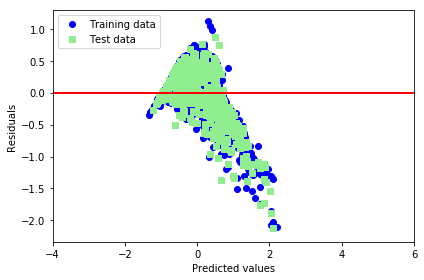


[Quadratic]
#Features: 45
MSE train: 0.11, test: 0.12
R^2 train: 0.89, test: 0.88


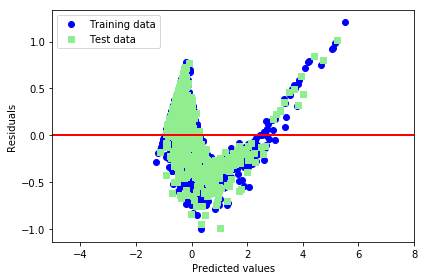


[Cubic]
#Features: 165
MSE train: 0.05, test: 0.05
R^2 train: 0.95, test: 0.95


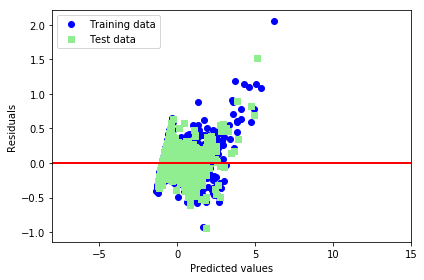

In [85]:
#linear regression
print('\n[Linear]')
regr1 = LinearRegressionSGD()
regr1.fit(X_train, y_train)

y_train_pred = regr1.predict(X_train)
y_test_pred = regr1.predict(X_test)

print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

plt.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c='blue',
    marker='o',
    label='Training data')
plt.scatter(
    y_test_pred,
    y_test_pred - y_test,
    c='lightgreen',
    marker='s',
    label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-4, 6])
plt.tight_layout()
plt.show()


#polynomial regression
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)

print('\n[Quadratic]')
X_quad_train = quadratic.fit_transform(X_train)
X_quad_test = quadratic.fit_transform(X_test)
print('#Features: %d' % X_quad_train.shape[1])
regr2 = LinearRegressionSGD()
regr2.fit(X_quad_train, y_train)
y_train_pred = regr2.predict(X_quad_train)
y_test_pred = regr2.predict(X_quad_test)
print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

plt.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c='blue',
    marker='o',
    label='Training data')
plt.scatter(
    y_test_pred,
    y_test_pred - y_test,
    c='lightgreen',
    marker='s',
    label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-5, 8])
plt.tight_layout()
plt.show()


print('\n[Cubic]')
X_cubic_train = cubic.fit_transform(X_train)
X_cubic_test = cubic.fit_transform(X_test)
print('#Features: %d' % X_cubic_train.shape[1])
regr3 = LinearRegressionSGD()
regr3.fit(X_cubic_train, y_train)
y_train_pred = regr3.predict(X_cubic_train)
y_test_pred = regr3.predict(X_cubic_test)
print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

plt.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c='blue',
    marker='o',
    label='Training data')
plt.scatter(
    y_test_pred,
    y_test_pred - y_test,
    c='lightgreen',
    marker='s',
    label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-8, 15])
plt.tight_layout()
plt.show()

### Random Forest Regression

MSE train: 0.35, test: 1.56
R^2 train: 1.00, test: 1.00


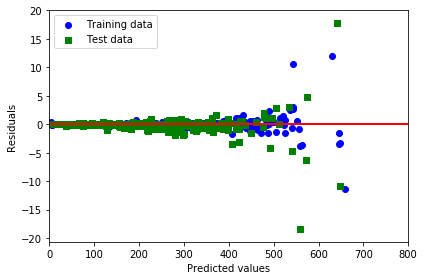

In [92]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)


forest = RandomForestRegressor(
    n_estimators=100, criterion='mse', random_state=1, n_jobs=10)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

# Residual plot
plt.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c='blue',
    marker='o',
    label='Training data')
plt.scatter(
    y_test_pred, y_test_pred - y_test, c='green', marker='s', label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=0, xmax=800, lw=2, color='red')
plt.xlim([0, 800])
plt.tight_layout()
plt.show()